In [1]:
import os
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")

# Tiltaksovervakingen: opsjon for kvalitetskontroll av analysedata

## Notebook 5: Exploring unusual values for Al fractions

Kjetil has asked us to look more closely at the values for Al fractions (RAl, ILAl and LAl) reported by VestfoldLAB during 2020. In 2019 there were also issues with these parameters, to the extent that all Al data were omitted from the upload to Vannmiljø in that year. Kjetil has noticed that LAl values for 2020 still seem quite high, and would like us to investigate further.

See e-mails from Kjetil and Øyvind received 27.01.2021 for details. Also note that on 28.01.2021 Kjetil supplied the omitted 2019 dataset for comparison.

## 1. Read raw data

In [2]:
# Choose dataset to process
lab = "Eurofins"
year = 2023
qtr = 1
version = 1

In [3]:
fold_path = f"../../output/{lab.lower()}_{year}_q{qtr}_v{version}"

In [4]:
# Read from SQLite
stn_df, df = utils.read_data_from_sqlite(lab, year, qtr, version)

# # Subset data to just the quarter of interest
# months_dict = {
#     "q1": [1, 2, 3],
#     "q2": [4, 5, 6],
#     "q3": [7, 8, 9],
#     "q4": [10, 11, 12],
# }
# months = months_dict[qtr]
# df = df[df["sample_date"].dt.month.isin(months)]

# Get just pH, TOC and Al fractions
cols = [
    "vannmiljo_code",
    "sample_date",
    "lab",
    "period",
    "depth1",
    "depth2",
    "RAL_µg/l Al",
    "ILAL_µg/l Al",
    "LAL_µg/l Al",
    "PH_<ubenevnt>",
    "TOC_mg/l C",
]
df = df[cols]

# Read 2019 data from Kjetil
df_2019 = pd.read_excel(r"../../data/al_ph_toc_2019_fra_kjetil.xlsx", sheet_name="Ark1")
df_2019["sample_date"] = pd.to_datetime(df_2019["sample_date"])

# Combine
df = pd.concat([df, df_2019])

# Join liming status
df = pd.merge(
    df, stn_df[["vannmiljo_code", "liming_status"]], how="left", on="vannmiljo_code"
)

# Reclassify liming status - see e-mail from Øyvind received 01.02.2021 for details
liming_reclass_dict = {
    "tidligere kalket": "Stable chemistry",
    "referanse": "Stable chemistry",
    "kalkes 2021": "Stable chemistry",
    "ukalket": "Stable chemistry",
    "terrengkalket tidligere": "Stable chemistry",
    "kalket": "Unstable chemistry",
    "silikatbehandlet": "Unstable chemistry",
    "terrengkalket 2019": "Unstable chemistry",
    "skjellsandkalket": "Unstable chemistry",
    "innsjøkalket (ref)": "Unstable chemistry",
}
df["liming_status"].replace(liming_reclass_dict, inplace=True)

df.head()

/tmp/ipykernel_9890/3161081051.py:32: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_2019["sample_date"] = pd.to_datetime(df_2019["sample_date"])


,vannmiljo_code,sample_date,lab,period,depth1,depth2,RAL_µg/l Al,ILAL_µg/l Al,LAL_µg/l Al,PH_<ubenevnt>,TOC_mg/l C,liming_status
0,002-105961,2023-01-02,Eurofins,new,0.0,0.0,42.0,33.0,9.0,6.3,14.0,Unstable chemistry
1,002-105961,2023-01-06,Eurofins,new,0.0,0.0,NaN,NaN,NaN,6.3,NaN,Unstable chemistry
2,002-105961,2023-01-30,Eurofins,new,0.0,0.0,55.0,44.0,11.0,6.2,15.0,Unstable chemistry
3,002-105961,2023-02-13,Eurofins,new,0.0,0.0,NaN,NaN,NaN,6.0,NaN,Unstable chemistry
4,002-105961,2023-02-20,Eurofins,new,0.0,0.0,NaN,NaN,NaN,6.2,NaN,Unstable chemistry


## 2. Scatterplots against pH and TOC

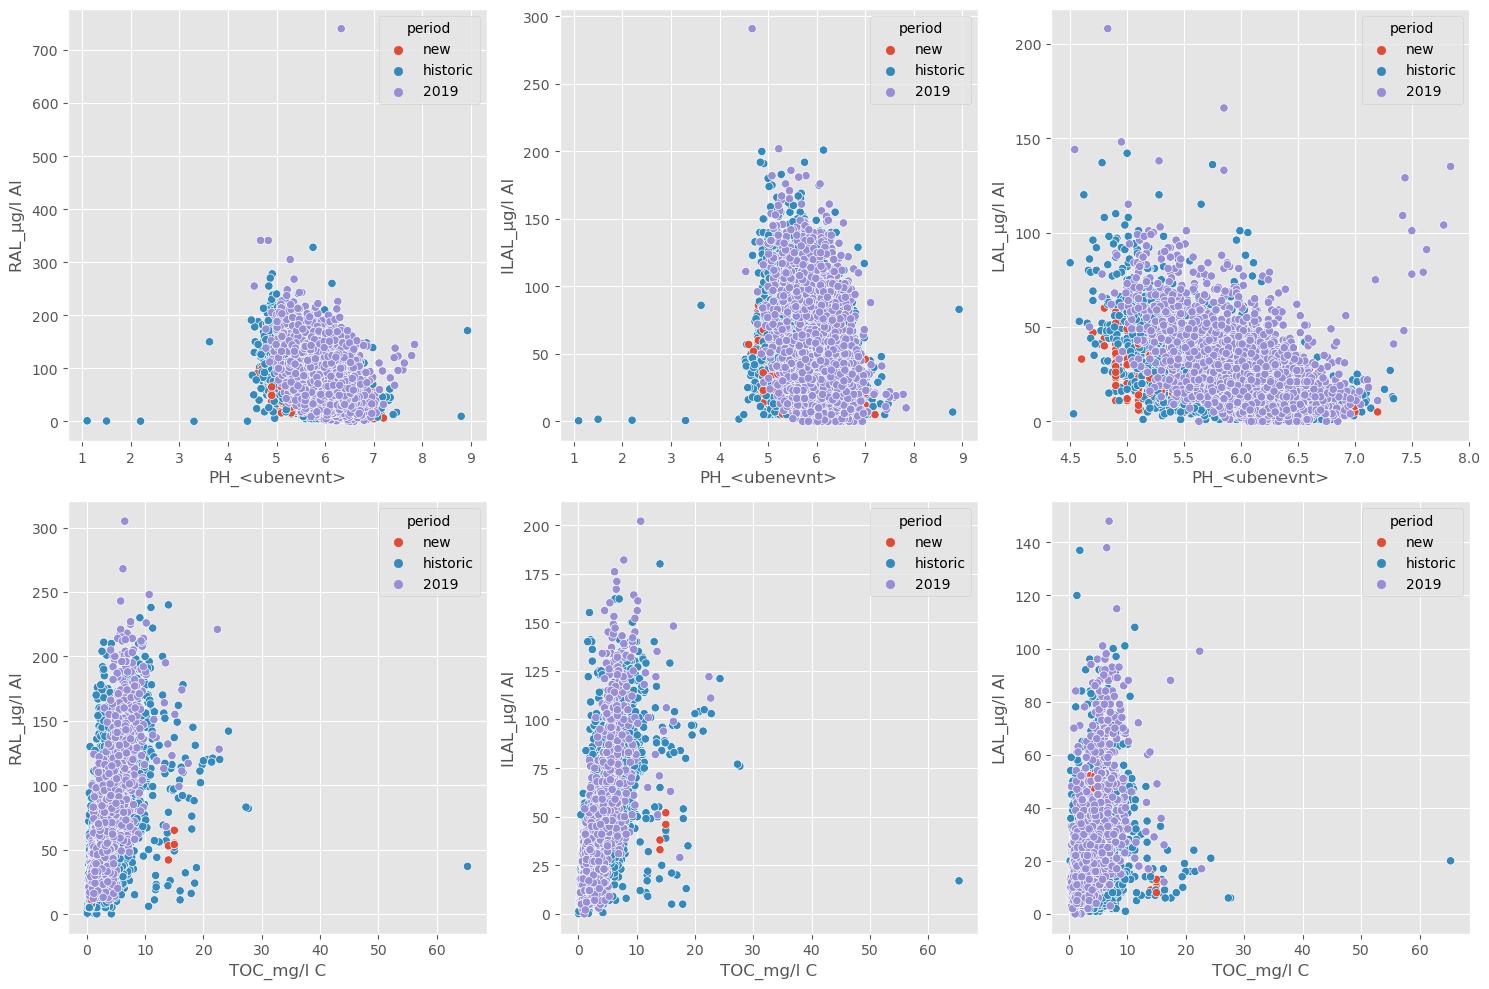

In [5]:
# Scatterplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for row_idx, xvar in enumerate(["PH_<ubenevnt>", "TOC_mg/l C"]):
    for col_idx, yvar in enumerate(["RAL_µg/l Al", "ILAL_µg/l Al", "LAL_µg/l Al"]):
        sn.scatterplot(data=df, x=xvar, y=yvar, hue="period", ax=axes[row_idx, col_idx])
plt.tight_layout()
png_path = os.path.join(fold_path, "al_ph_toc_scatter.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")

The scatterplots show that there are no really dramatic differences between these three groups of data: the majority of the data overlap one another, and the general relationships with pH and TOC are similar. However, the "centre of mass" of the data clouds is subtly different in each case. This can be visualised more clearly by considering the data distributions in more detail.

## 3. Data distributions for Al fractions

### 3.1. By data collection period

The left column of plots below shows kernel-density-smoothed estimates of the raw data distributions; the right column shows the empirical cumulative density function (ECDF) for each series. Note the following:

 * For RAl, the distributions for the `historic` and `new` (= 2020) datasets are broadly the same, but the distribution for 2019 is more right-skewed. This means the 2019 dataset includes an unusually large proportion of high concentrations compared to the reference and 2020 datasets
 
 * For ILAl, the 2019 dataset has unusually high values compared to the reference, whereas the 2020 dataset has unusually low values compared to the reference
 
 * Values for LAl are unusually high compared to the reference in both 2019 and 2020, and the distributions for these two years are similar. However, the causes of the change are slightly different in each year: in 2019, RAl values increase a lot and ILAl values increase a little, so the difference between the two also increases a little compared to previously; in 2020, RAl remains fairly steady, but ILAl decreases substantially and, overall, LAl increases by a similar amount to 2019

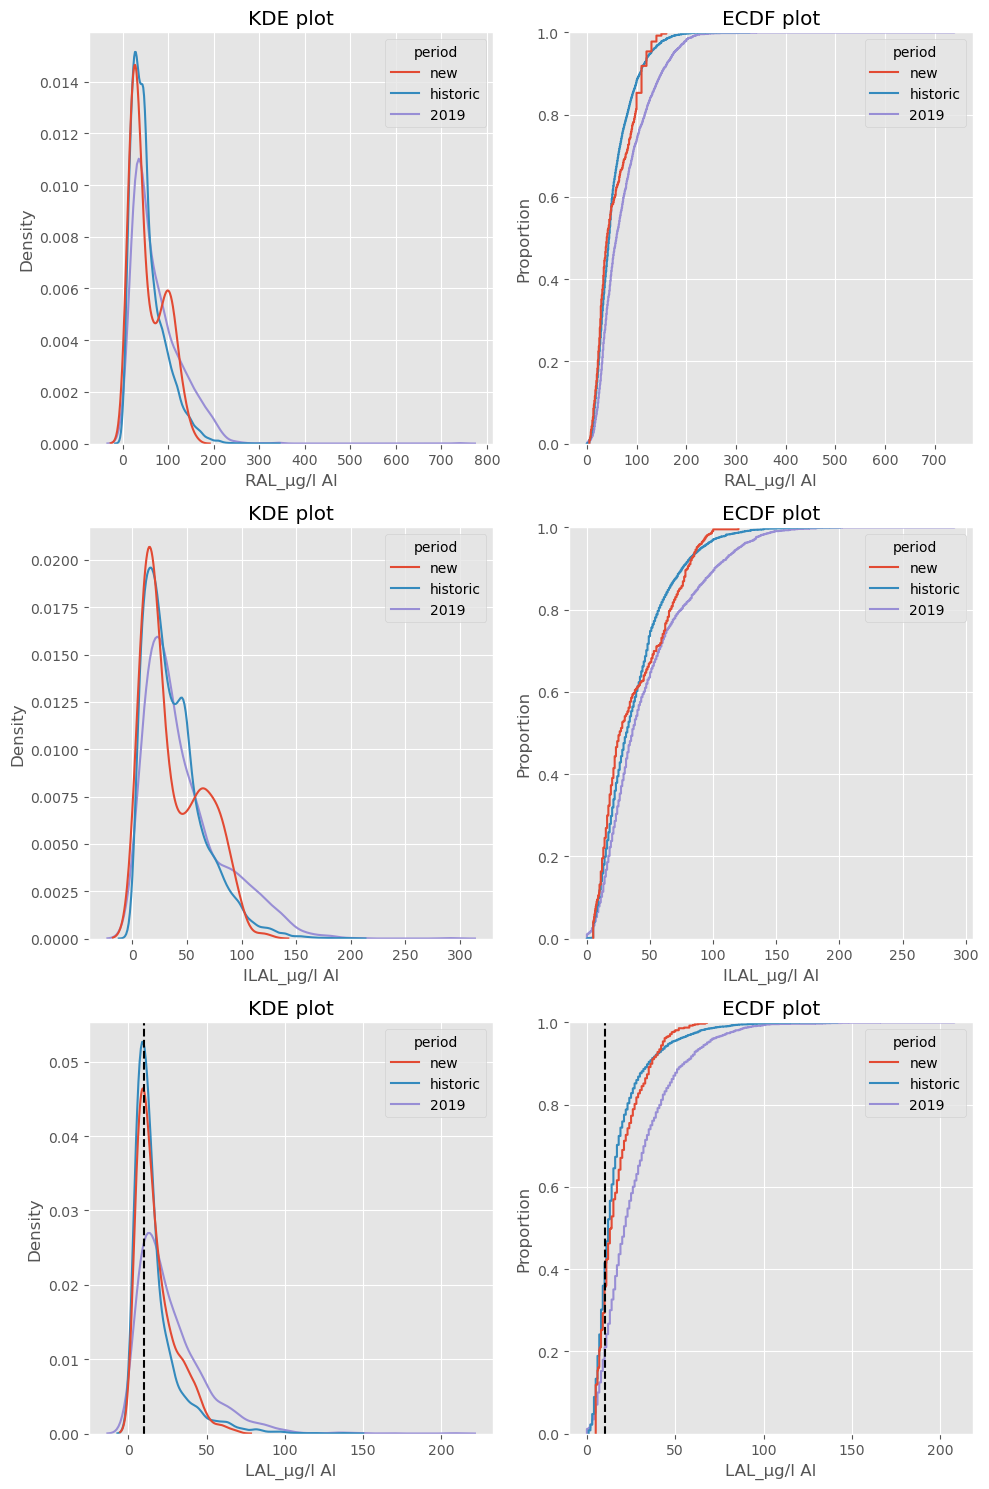

In [6]:
# Dist plots by period
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

for row, par in enumerate(["RAL_µg/l Al", "ILAL_µg/l Al", "LAL_µg/l Al"]):
    sn.kdeplot(data=df, x=par, hue="period", common_norm=False, ax=axes[row, 0])
    sn.ecdfplot(data=df, x=par, hue="period", ax=axes[row, 1])

    if par == "LAL_µg/l Al":
        axes[row, 0].axvline(10, c="k", ls="--")
        axes[row, 1].axvline(10, c="k", ls="--")

    axes[row, 0].set_title("KDE plot")
    axes[row, 1].set_title("ECDF plot")

plt.tight_layout()
png_path = os.path.join(fold_path, "al_fracs_displots_by_period.png")
plt.savefig(
    png_path,
    dpi=200,
    bbox_inches="tight",
)

### 3.2. By period and liming status

The plots below group the data by both period and "liming status", where the original liming categories have been grouped as follows:

 * Tidligere kalket => Stable chemistry
 * Referanse => Stable chemistry
 * Kalkes 2021 => Stable chemistry
 * Ukalket => Stable chemistry
 * Terrengkalket tidligere => Stable chemistry
 
 * Kalket => Unstable chemistry
 * Silikatbehandlet => Unstable chemistry
 * Terrengkalket 2019 => Unstable chemistry
 * Skjellsandkalket => Unstable chemistry
 * Innsjøkalket (ref) => Unstable chemistry

This has been done because one hypothesis put forward during the original investigation of the 2019 dataset was that longer delays in analysing the samples allowed re-equilibration between particulate and dissolved Al species, which may have skewed the 2019 results. Øyvind has pointed out that this is more likely to be an issue at sites being actively limed ("Unstable chemistry" in the list above). If this hypothesis is correct, we might therefore expect to see similar distributions for each time period in the "Stable chemistry" (left) column, and bigger differences in the "Unstable chemistry" (right) column.

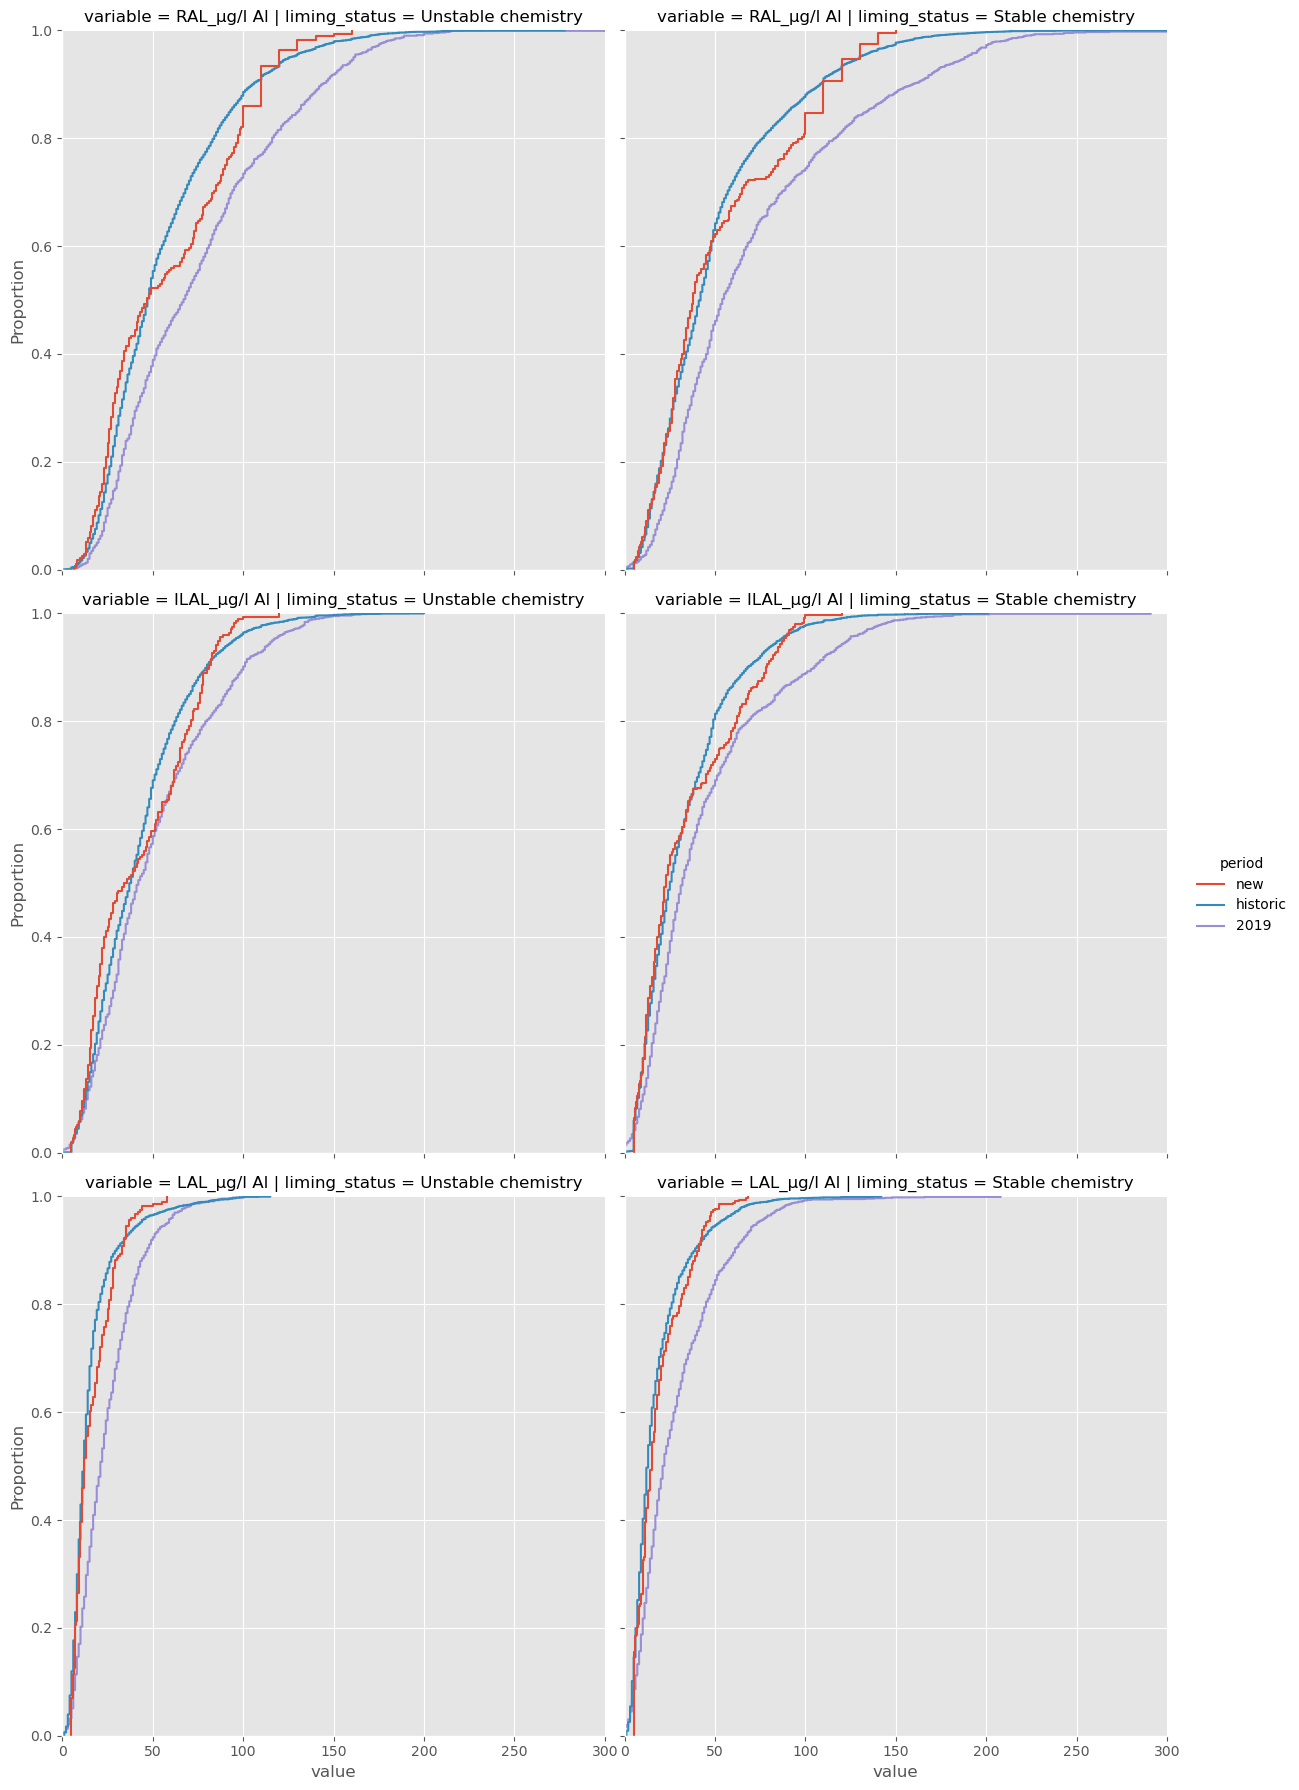

In [7]:
# Dist plots by period and liming status
df2 = (
    df[["period", "liming_status", "RAL_µg/l Al", "ILAL_µg/l Al", "LAL_µg/l Al"]]
    .melt(id_vars=["period", "liming_status"])
    .dropna(subset=["value"])
)
g = sn.displot(
    kind="ecdf",
    x="value",
    row="variable",
    col="liming_status",
    hue="period",
    data=df2,
    height=6,
)
g.set(xlim=(0, 300))
png_path = os.path.join(fold_path, "al_fracs_displots_by_period_and_liming_status.png")
plt.savefig(
    png_path,
    dpi=200,
    bbox_inches="tight",
)